#IMPORT LIBRARY

In [59]:
import json
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# !pip install deap


#LOADING AND PROCESSING DATA

In [60]:
#BTC thay đường dẫn đến file data.json của nhóm để chạy thử
with open("data.json", 'r', encoding='utf-8') as f:
    data=json.load(f)

In [61]:
name_list = data[0]['name']
info_list = data[0]['employee_info']

list_0 = []
list_1 = []
list_2 = []
name_0 = []
name_1 = []
name_2 = []

for i in range(len(info_list)):
    if info_list[i][1] == 0:
        list_0.append(info_list[i])
        name_0.append(name_list[i])
    elif info_list[i][1] == 1:
        list_1.append(info_list[i])
        name_1.append(name_list[i])
    elif info_list[i][1] == 2:
        list_2.append(info_list[i])
        name_2.append(name_list[i])
assert len(name_list) == len(info_list)

In [62]:
DAYS_NUM = data[1]["Days"]
POPULATION_SIZE = data[2]["POPULATION_SIZE"]
MAX_GENERATION = 1000
P_CROSSOVER = data[2]["P_CROSSOVER"]
P_MUTATION = 0.15
HARD_CONSTRAINT_PENALTY = data[1]["HARD_CONSTRAINT_PENALTY"]
MAX_NUMBER_EMPLOYEE_PER_DAY = 4

#GENETIC ALGORITHM

In [63]:
np.random.seed(42)
random.seed(42)

In [64]:
def get_random_employee(name_list, data_list):
  size = len(name_list)
  index = random.randint(0,size-1)

  return name_list[index], data_list[index]

In [65]:
def init_random_scheduler_with_hard_constrain(name_0, list_0, name_1, list_1, name_2, list_2):
    m = DAYS_NUM
    n = MAX_NUMBER_EMPLOYEE_PER_DAY # normally = 4

    schedule = np.empty((m, n), dtype=object)

    for day in range(m):
        schedule[day][0] = get_random_employee(name_0, list_0)
        schedule[day][1] = get_random_employee(name_1, list_1)
        schedule[day][2] = get_random_employee(name_2, list_2)
        schedule[day][3] = get_random_employee(name_2, list_2)
        while (schedule[day][2] == schedule[day][3]):
            schedule[day][3] = get_random_employee(name_2, list_2)
    return schedule

##CROSSOVER

Uniform Crossover


In [66]:
def uniform_crossover(parent1, parent2):
    child1 = np.copy(parent1)
    child2 = np.copy(parent2)

    for i in range(DAYS_NUM):
      if random.random() < P_CROSSOVER:
        child1[i], child2[i] = parent2[i], parent1[i]
    # for i in range(DAYS_NUM):
    #  for j in range(MAX_NUMBER_EMPLOYEE_PER_DAY):
    #    if random.random() < P_CROSSOVER:
    #      child1[i][j], child2[i][j] = parent2[i][j], parent1[i][j]
    return child1, child2


## MUTATION

In [67]:
def mutate(schedule):
    day = random.randint(0, DAYS_NUM - 1)
    dept = random.randint(0, 3)
    if (dept == 0):
        mutate_employee = get_random_employee(name_0, list_0)
    elif (dept == 1):
        mutate_employee = get_random_employee(name_1, list_1)
    else:
        mutate_employee = get_random_employee(name_2, list_2)
    schedule[day][dept] = mutate_employee
    return schedule

##FITNESS FUNCTION

### Faculty Diversity Constraint

In [68]:
def faculty_diversity_constraint_penalty(schedule):
  diff = 0
  for day in range(DAYS_NUM):
         faculty = [item[1][0] for item in schedule[day]]
         if len(set(faculty)) == 1:
            diff+=3
         elif len(set(faculty)) == 2:
            diff+=2
         elif len(set(faculty)) == 3:
            diff+=1
  return diff



### Seniority Constraint

In [69]:
senior_list_0 = [sublist[2] for sublist in list_0]
senior_list_1 = [sublist[2] for sublist in list_1]
senior_list_2 = [sublist[2] for sublist in list_2]
senior_list = [a[2] for a in info_list]

average_list_0 = sum(sublist[2] for sublist in list_0) / len(list_0)
average_list_1 = sum(sublist[2] for sublist in list_1) / len(list_1)
average_list_2 = sum(sublist[2] for sublist in list_2) / len(list_2)
average_all = sum(sublist[2] for sublist in info_list) / len(info_list)

In [70]:
p0 = np.percentile(senior_list_0,75)
p1 = np.percentile(senior_list_1,75)
p2 = np.percentile(senior_list_2,75)

In [71]:
def seniority_constraint_penalty(schedule):
   seniority_penalty =0
   for day in range(DAYS_NUM):
      if (schedule[day][0][1][2] < p0
          and schedule[day][1][1][2] < p1
          and schedule[day][2][1][2] < p2
          and schedule[day][3][1][2] < p2):
        maxx = max([schedule[day][0][1][2], schedule[day][1][1][2], schedule[day][2][1][2], schedule[day][3][1][2] ])
        seniority_penalty += np.abs(average_all - maxx)
   return seniority_penalty

### Schedule Constraint

In [72]:
def create_schedule_dict(scheduler):
    schedule_dict = {}
    for day, shift in enumerate(scheduler, start=1):
        for employee in shift:
            name, info = employee
            key = (name, tuple(info))
            if key not in schedule_dict:
                schedule_dict[key] = []
            schedule_dict[key].append(day)
    return schedule_dict

In [73]:
def schedule_constraint_penalty(schedule):
     b_0 = list(zip(name_0,list_0))
     b_1 = list(zip(name_1,list_1))
     b_2 = list(zip(name_2,list_2))


     sched_0 = [-1]*len(list_0)
     sched_1 = [-1]*len(list_1)
     sched_2 = [-1]*len(list_2)
     sched_penalty = 0
     for day in range(DAYS_NUM):
      index = b_0.index(schedule[day][0])
      if sched_0[index] != -1 and not(day - sched_0[index] <= 19 and day - sched_0[index] >=16) :
        sched_penalty += np.abs(17.5 - (day - sched_0[index]))
      sched_0[index] = day
    # bác sĩ cọc II
      index = b_1.index(schedule[day][1])
      if sched_1[index] != -1 and not(day - sched_1[index] <= 17 and day - sched_1[index] >=13):
        sched_penalty += np.abs(15 - (day - sched_1[index]))
      sched_1[index] = day
    # điều dưỡng 1
      index = b_2.index(schedule[day][2])
      if sched_2[index] != -1 and not(day - sched_2[index] <= 20 and day - sched_2[index] >=15):
        sched_penalty += np.abs(17.5 - (day - sched_2[index]))
      sched_2[index] = day
    # điều dưỡng 2
      index = b_2.index(schedule[day][3])
      if sched_2[index] != -1 and not(day - sched_2[index] <= 20 and day - sched_2[index] >=15):
        sched_penalty += np.abs(17.5 - (day - sched_2[index]))
      sched_2[index] = day
     for _ in range(len(list_0)):
      if sched_0[_] == -1 :
         sched_penalty+=10
     for _ in range(len(list_1)):
      if sched_1[_] == -1:
         sched_penalty+=10
     for _ in range(len(list_2)):
      if sched_2[_] == -1 :
         sched_penalty+=10

     schedule_dict = create_schedule_dict(schedule)
     for key, value in schedule_dict.items():
      if key[1][1] == 2:
        if len(value) > 3:
          sched_penalty+=10
      if key[1][1] == 0 or key[1][1] == 1:
        if len(value)> 4:
          sched_penalty+=10

     return sched_penalty


##SELECTION

In [74]:
def tournament_selection(population, scores, k=3):
    selected_indices = np.random.randint(len(population), size=k)
    selected_schedules = [population[i] for i in selected_indices]
    selected_scores = [scores[i] for i in selected_indices]

    best_schedule_index = selected_scores.index(min(selected_scores))
    return selected_schedules[best_schedule_index]



In [75]:
from time import daylight

def evaluate(schedule):
  a = faculty_diversity_constraint_penalty(schedule)
  b = seniority_constraint_penalty(schedule)
  c = schedule_constraint_penalty(schedule)
  return 0.7*a + 0.1*b + 0.2*c

##GA BASELINE

In [76]:
def genetic_algorithm():
    population = [init_random_scheduler_with_hard_constrain(name_0, list_0, name_1, list_1, name_2, list_2) for _ in range(POPULATION_SIZE)]
    best_schedule = None
    best_score = float('inf')
    best_score_history = []
    mean_score_history = []


    for generation in range(1000):
        scores = [evaluate(schedule) for schedule in population]

        for i, score in enumerate(scores):
            if score < best_score:
                best_score = score
                best_schedule = population[i]
        mean = sum(scores) / len(scores)
        mean_score_history.append(mean)
        best_score_history.append(best_score)


        next_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1 = tournament_selection(population, scores)
            parent2 = tournament_selection(population, scores)
            child1, child2 = uniform_crossover(np.copy(parent1), np.copy(parent2))
            if random.random() < P_MUTATION:
                child1 = mutate(child1)
            if random.random() < P_MUTATION:
                child2 = mutate(child2)
            next_population.append(child1)
            next_population.append(child2)

        population = next_population
        print(f"Generation {generation}, Best Score: {best_score}, Mean Score: {mean}")

    return best_schedule, best_score_history, mean_score_history


In [77]:
best_schedule, best_score_history, mean_score_history = genetic_algorithm()

Generation 0, Best Score: 374.6, Mean Score: 433.4516125000001
Generation 1, Best Score: 374.6, Mean Score: 427.61229583333375
Generation 2, Best Score: 374.6, Mean Score: 424.8771583333331
Generation 3, Best Score: 371.3425, Mean Score: 420.45783333333344
Generation 4, Best Score: 360.3125, Mean Score: 419.41343333333333
Generation 5, Best Score: 360.3125, Mean Score: 417.22359583333343
Generation 6, Best Score: 360.3125, Mean Score: 414.86905000000013
Generation 7, Best Score: 360.3125, Mean Score: 416.1997791666666
Generation 8, Best Score: 360.3125, Mean Score: 413.46121250000004
Generation 9, Best Score: 360.3125, Mean Score: 413.3826583333331
Generation 10, Best Score: 360.3125, Mean Score: 410.25869166666683
Generation 11, Best Score: 353.13, Mean Score: 406.56429583333335
Generation 12, Best Score: 352.9475, Mean Score: 404.9964666666667
Generation 13, Best Score: 352.9475, Mean Score: 404.65555833333315
Generation 14, Best Score: 347.33000000000004, Mean Score: 403.16641250000

#VISUALIZATION

In [78]:
def visualize_scores(best_score_history, mean_score_history):
    plt.plot(best_score_history, label='Best Score')
    plt.plot(mean_score_history, label='Mean Score')
    plt.xlabel('Generation')
    plt.ylabel('Fitness Score')
    plt.title('Best and Mean Fitness Score per Generation')
    plt.legend()
    plt.show()

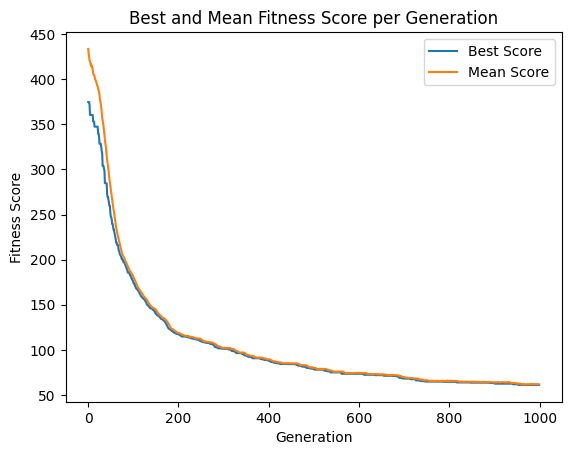

In [79]:
visualize_scores(best_score_history,mean_score_history)

In [80]:
for i in range(DAYS_NUM):
  print(f'Day {i+1:<3}: '
          f'{best_schedule[i][0][0]:<13}' + ' '.join(f'{str(item):<3}' for item in best_schedule[i][0][1]),"| ",
          f'{best_schedule[i][1][0]:<13}' + ' '.join(f'{str(item):<3}' for item in best_schedule[i][1][1]),"| ",
          f'{best_schedule[i][2][0]:<13} '+ ' '.join(f'{str(item):<3}' for item in best_schedule[i][2][1]),"| ",
          f'{best_schedule[i][3][0]:<13} '+ ' '.join(f'{str(item):<3}' for item in best_schedule[i][3][1]),"; ",)


Day 1  : Thanh Hà     1   0   6   |  Hưng         0   1   4   |  Quỳnh         2   2   13  |  Vượng         3   2   19  ; 
Day 2  : Hường        0   0   3   |  Hương        3   1   5   |  Nam           1   2   18  |  Ngọc          2   2   14  ; 
Day 3  : Linh         1   0   13  |  Dũng         2   1   6   |  An            0   2   2   |  Linh          0   2   3   ; 
Day 4  : Bá Tuấn      3   0   16  |  Thắng        0   1   9   |  Lương         2   2   8   |  Thành         3   2   22  ; 
Day 5  : Thương       1   0   2   |  Minh Phương  3   1   14  |  Sang          2   2   17  |  Dung          2   2   5   ; 
Day 6  : Tâm          2   0   17  |  Linh         3   1   12  |  Tuyến         0   2   16  |  Hoài          1   2   9   ; 
Day 7  : Thư          0   0   7   |  Hà           3   1   3   |  Long          2   2   18  |  Oanh          2   2   11  ; 
Day 8  : Thùy         2   0   11  |  Giang        1   1   10  |  Dương         0   2   10  |  Huyền         3   2   21  ; 
Day 9  : Tuấn   

In [81]:
schedule_dict = create_schedule_dict(best_schedule)
print(schedule_dict)

{('Thanh Hà', (1, 0, 6)): [1, 19], ('Hưng', (0, 1, 4)): [1, 15, 29, 43], ('Quỳnh', (2, 2, 13)): [1, 19, 39, 55], ('Vượng', (3, 2, 19)): [1, 21, 41], ('Hường', (0, 0, 3)): [2, 23, 42, 57], ('Hương', (3, 1, 5)): [2, 14, 28, 44], ('Nam', (1, 2, 18)): [2, 14, 31, 46, 61], ('Ngọc', (2, 2, 14)): [2, 16], ('Linh', (1, 0, 13)): [3, 20], ('Dũng', (2, 1, 6)): [3, 21, 35, 52], ('An', (0, 2, 2)): [3, 22, 39], ('Linh', (0, 2, 3)): [3, 20, 38], ('Bá Tuấn', (3, 0, 16)): [4, 22, 35], ('Thắng', (0, 1, 9)): [4, 17, 32, 48], ('Lương', (2, 2, 8)): [4, 22], ('Thành', (3, 2, 22)): [4, 24, 44], ('Thương', (1, 0, 2)): [5, 21, 39, 55], ('Minh Phương', (3, 1, 14)): [5, 20], ('Sang', (2, 2, 17)): [5, 20, 40], ('Dung', (2, 2, 5)): [5, 23], ('Tâm', (2, 0, 17)): [6, 24, 38, 54], ('Linh', (3, 1, 12)): [6], ('Tuyến', (0, 2, 16)): [6, 27, 51], ('Hoài', (1, 2, 9)): [6, 24, 41], ('Thư', (0, 0, 7)): [7, 18, 37, 53], ('Hà', (3, 1, 3)): [7, 22, 42, 56], ('Long', (2, 2, 18)): [7, 16, 32], ('Oanh', (2, 2, 11)): [7, 26, 42], 

In [82]:
print("Số thành viên được phân ca trực = ", len(schedule_dict))

Số thành viên được phân ca trực =  80


In [83]:
print("Các thành viên trực ngoài số ngày quy định: ")
for key, value in schedule_dict.items():
      if key[1][1] == 2:
        if len(value) >= 4 or len(value) < 3:
          print(key, value)
      if key[1][1] == 0 or key[1][1] == 1:
        if len(value) < 3 or len(value)>=5:
          print(key, value)

Các thành viên trực ngoài số ngày quy định: 
('Thanh Hà', (1, 0, 6)) [1, 19]
('Quỳnh', (2, 2, 13)) [1, 19, 39, 55]
('Nam', (1, 2, 18)) [2, 14, 31, 46, 61]
('Ngọc', (2, 2, 14)) [2, 16]
('Linh', (1, 0, 13)) [3, 20]
('Lương', (2, 2, 8)) [4, 22]
('Minh Phương', (3, 1, 14)) [5, 20]
('Dung', (2, 2, 5)) [5, 23]
('Linh', (3, 1, 12)) [6]
('Huyền', (3, 2, 21)) [8, 23]
('Thuận', (1, 1, 8)) [37, 53]
('Len', (2, 2, 9)) [38, 57]
('Ngân Hà', (1, 0, 10)) [40, 56]
('Đông', (3, 2, 11)) [43, 60]
('Huệ', (1, 2, 12)) [45, 58]
('Thu', (1, 2, 15)) [52]
('Kim Anh', (3, 2, 6)) [53]
('Hưng', (3, 2, 15)) [58]


In [84]:
print("Faculty Penalty = ", faculty_diversity_constraint_penalty(best_schedule))

Faculty Penalty =  35


In [85]:
print("Seniority Penalty = ", seniority_constraint_penalty(best_schedule))

Seniority Penalty =  22.0625


In [86]:
print("Schedule Penalty = ", schedule_constraint_penalty(best_schedule))

Schedule Penalty =  172.5


#EXPORT TO CSV FILE

In [87]:
from datetime import datetime, timedelta
import csv

# BTC thay đổi đường dẫn phù hợp để xuất file output
def export_schedule_to_csv(schedule, filename='output_main.csv'):
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Ngày', 'Bác sỹ cọc 1', 'Bác sỹ cọc 2', 'Điều dưỡng 1', 'Điều dưỡng 2'])


        start_date = datetime(2024, 8, 1)

        for i, day in enumerate(schedule):
            current_date = start_date + timedelta(days=i)
            formatted_date = current_date.strftime("%d-%m-%Y")
            row = [
                formatted_date,
                f'{day[0][0]}-{day[0][1]}',
                f'{day[1][0]}-{day[1][1]}',
                f'{day[2][0]}-{day[2][1]}',
                f'{day[3][0]}-{day[3][1]}'
            ]
            writer.writerow(row)

In [88]:
export_schedule_to_csv(best_schedule)